In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv(r"C:\Users\DELL\Downloads\SampleSuperstore.csv", encoding='latin1')
print(df)


      Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2016-152156  11-08-2016  11-11-2016    Second Class   
1          2  CA-2016-152156  11-08-2016  11-11-2016    Second Class   
2          3  CA-2016-138688  06-12-2016   6-16-2016    Second Class   
3          4  US-2015-108966  10-11-2015  10-18-2015  Standard Class   
4          5  US-2015-108966  10-11-2015  10-18-2015  Standard Class   
...      ...             ...         ...         ...             ...   
9989    9990  CA-2014-110422   1-21-2014   1-23-2014    Second Class   
9990    9991  CA-2017-121258   2-26-2017  03-03-2017  Standard Class   
9991    9992  CA-2017-121258   2-26-2017  03-03-2017  Standard Class   
9992    9993  CA-2017-121258   2-26-2017  03-03-2017  Standard Class   
9993    9994  CA-2017-119914  05-04-2017  05-09-2017    Second Class   

     Customer ID     Customer Name    Segment        Country             City  \
0       CG-12520       Claire Gute   Consumer  United 

In [ ]:
print(df.head(5))

# Convert Order Date to datetime> 0]


In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Latest date for Recency calculation

In [8]:
latest_date = df['Order Date'].max()

# Group by Customer and calculate RFM metrics

In [9]:
rfm = df.groupby('Customer Name').agg({
    'Order Date': lambda x: (latest_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                                  # Frequency
    'Sales': 'sum'                                          # Monetary
}).reset_index()

# Rename columns

In [10]:
rfm.columns = ['Customer Name', 'Recency', 'Frequency', 'Monetary']

# RFM Scoring (1 to 4 scale)

In [11]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# RFM Segment and Score

In [12]:
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Define Loyalty Levels

In [13]:
rfm['Customer_Level'] = pd.cut(rfm['RFM_Score'], bins=[2, 5, 8, 11, 12],
                               labels=['Low-Value', 'Mid-Value', 'High-Value', 'Top-Value'])

print(rfm.head())

     Customer Name  Recency  Frequency  Monetary  R  F  M RFM_Segment  \
0    Aaron Bergman      415          3   886.156  1  1  1         111   
1    Aaron Hawkins       12          7  1744.700  4  3  2         432   
2   Aaron Smayling       88          7  3050.692  2  3  3         233   
3  Adam Bellavance       54          8  7755.620  3  3  4         334   
4        Adam Hart       34         10  3250.337  3  4  3         343   

   RFM_Score Customer_Level  
0          3      Low-Value  
1          9     High-Value  
2          8      Mid-Value  
3         10     High-Value  
4         10     High-Value  


# Plot RFM Distributions

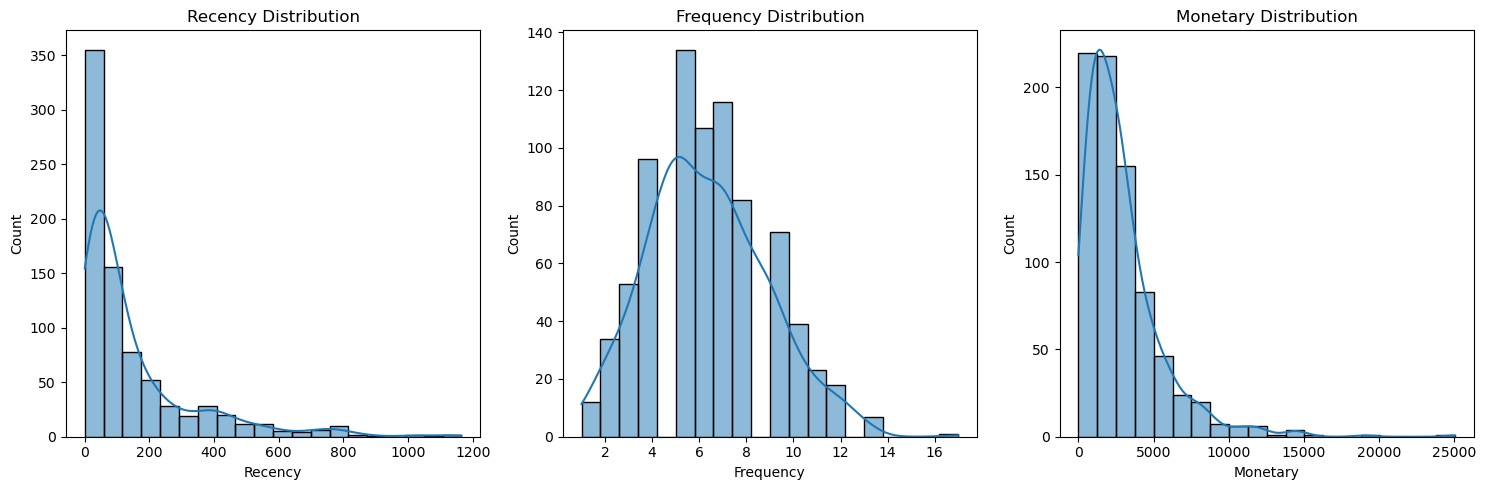

In [14]:
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(rfm[metric], bins=20, kde=True)
    plt.title(f'{metric} Distribution')
plt.tight_layout()
plt.show()

# Heatmap of RFM Segments

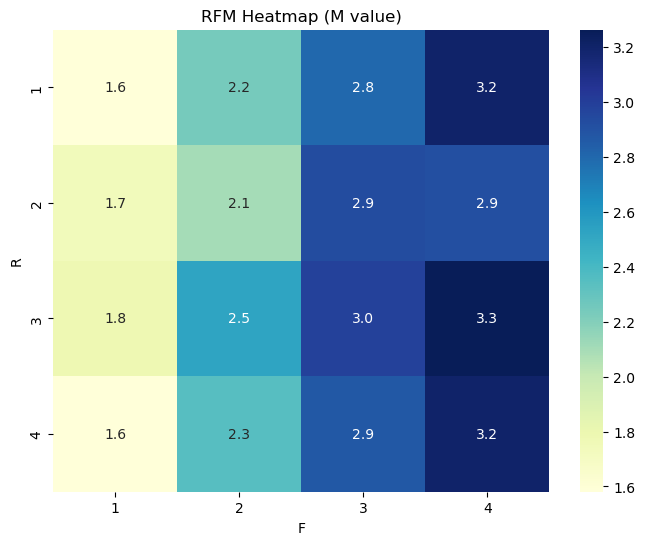

In [15]:
rfm_segment_pivot = rfm.pivot_table(index='R', columns='F', values='M', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_segment_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('RFM Heatmap (M value)')
plt.show()